In [6]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train a NN with class weights

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def getData(dataset="train"):
  data = pd.read_csv('/content/drive/My Drive/Mila/DS/' + dataset + '.csv')
  x_train = data.iloc[:,0:20]
  x_train = x_train.drop(["gameId", "time", "period"], axis=1)
  # x_train = x_train.drop(["gameId"], axis=1)
  y_train = data.iloc[:,-1:].to_numpy()
  return (x_train.to_numpy(), y_train)

x_train, y_train = getData()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [8]:
neg, pos = np.bincount(y_train[:, 0])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.4f}% of total)\n'.format(
    total, pos, 100 * pos / total))

weight_for_0 = (1 / neg)*(total)/2
weight_for_1 = (1 / pos)*(total)/2

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 252425
    Positive: 25233 (9.9962% of total)

Weight for class 0: 0.56
Weight for class 1: 5.00


In [9]:
from tensorflow import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializers.Constant(output_bias)

  model = keras.Sequential(
      [
          keras.layers.Dense(
              1024, activation="relu", input_shape=(x_train.shape[-1],)
          ),
          keras.layers.Dense(1024, activation="relu"),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(1024, activation="relu"),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(1, activation="sigmoid"),
      ]
  )

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  model.summary()
  return model

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

class_weight = {0: weight_for_0, 1: weight_for_1}
initial_bias = np.log([pos/neg])

model_weighted = make_model(output_bias=initial_bias)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              18432     
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 2,118,657
Trainable params: 2,118,657
No

In [10]:
weighted_history = model_weighted.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    callbacks = [early_stopping],
    validation_data=(x_val, y_val),
    # validation_split = 0.2,
    class_weight=class_weight) 

Epoch 1/100
124/124 - 7s - loss: 1.1148 - tp: 16328.0000 - fp: 88116.0000 - tn: 139076.0000 - fn: 8905.0000 - accuracy: 0.6156 - precision: 0.1563 - recall: 0.6471 - auc: 0.6589 - prc: 0.1547 - val_loss: 0.5793 - val_tp: 4419.0000 - val_fp: 18680.0000 - val_tn: 38100.0000 - val_fn: 1908.0000 - val_accuracy: 0.6738 - val_precision: 0.1913 - val_recall: 0.6984 - val_auc: 0.7421 - val_prc: 0.2287 - 7s/epoch - 58ms/step
Epoch 2/100
124/124 - 2s - loss: 0.6086 - tp: 17841.0000 - fp: 78881.0000 - tn: 148311.0000 - fn: 7392.0000 - accuracy: 0.6582 - precision: 0.1845 - recall: 0.7071 - auc: 0.7327 - prc: 0.2195 - val_loss: 0.6187 - val_tp: 4509.0000 - val_fp: 19399.0000 - val_tn: 37381.0000 - val_fn: 1818.0000 - val_accuracy: 0.6638 - val_precision: 0.1886 - val_recall: 0.7127 - val_auc: 0.7430 - val_prc: 0.2334 - 2s/epoch - 17ms/step
Epoch 3/100
124/124 - 2s - loss: 0.6035 - tp: 17840.0000 - fp: 78417.0000 - tn: 148775.0000 - fn: 7393.0000 - accuracy: 0.6601 - precision: 0.1853 - recall: 0.7

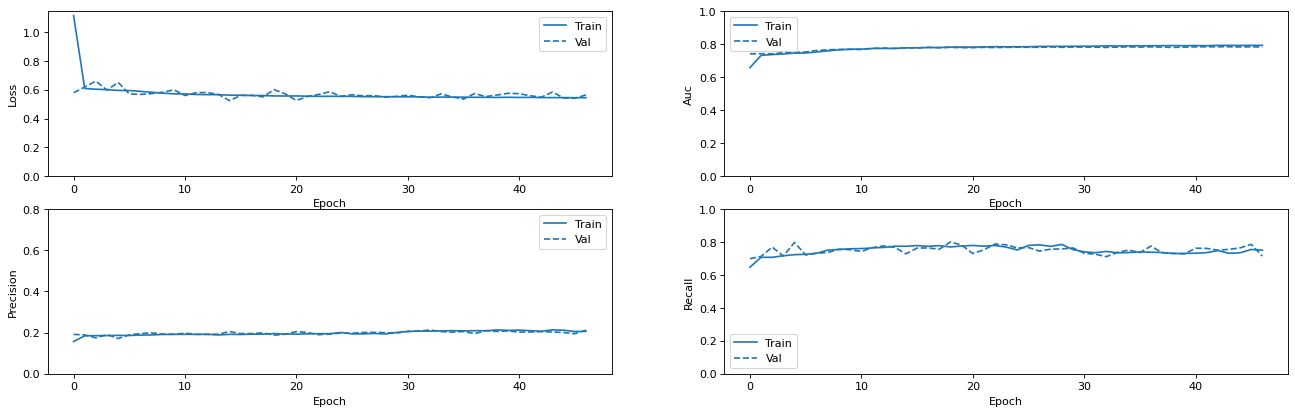

In [11]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20, 6), dpi=80)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0, 1])
    elif metric == 'precision':
      plt.ylim([0, 0.8])
    else:
      plt.ylim([0,1])
    plt.legend()

plot_metrics(weighted_history)

# Test class weights

In [12]:
def plot_cm(labels, predictions, p=0.5, name="Test"):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(name)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

4/4 [==============================] - 0s 5ms/step


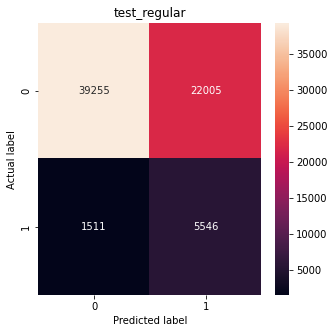

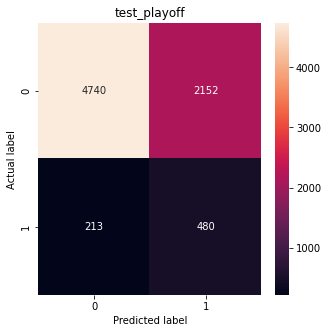

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

dataset_test = "test_regular"
x_test, y_test = getData(dataset_test)
y_pred = model_weighted.predict(x_test, batch_size=BATCH_SIZE)
resampled_results = model_weighted.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
plot_cm(y_test, y_pred, name=dataset_test)

dataset_test = "test_playoff"
x_test, y_test = getData(dataset_test)
y_pred = model_weighted.predict(x_test, batch_size=BATCH_SIZE)
resampled_results = model_weighted.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
plot_cm(y_test, y_pred, name=dataset_test)

# Train a NN with Oversampling

In [23]:
bool_train_labels = y_train != 0

pos_features = x_train[bool_train_labels.flatten()]
neg_features = x_train[~bool_train_labels.flatten()]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

from tensorflow import data
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = data.Dataset.from_tensor_slices((features, labels))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

resampled_ds = data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

Features:
 [-35.      20.      57.5847  20.3231   6.       0.      16.      73.
  14.      27.     108.1665   0.       0.       4.0062   5.       5.
   0.    ]

Label:  1
0.5078125


222.0

In [24]:
model_resampled = make_model()

output_layer = model_resampled.layers[-1] 
output_layer.bias.assign([0])

val_ds = data.Dataset.from_tensor_slices((x_val, y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = model_resampled.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1024)              18432     
                                                                 
 dense_17 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 2,118,657
Trainable params: 2,118,657
No

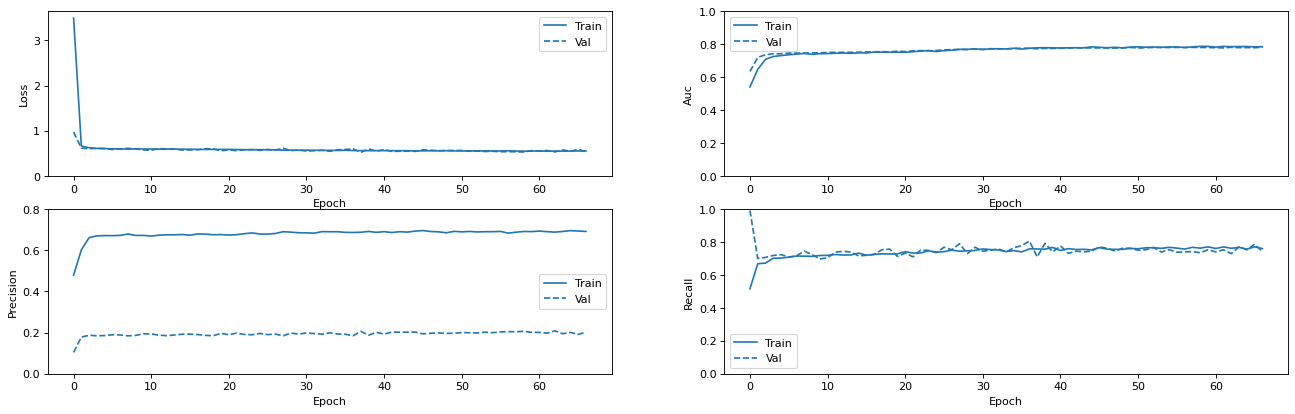

In [25]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  plt.figure(figsize=(20, 6), dpi=80)
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0, 1])
    elif metric == 'precision':
      plt.ylim([0, 0.8])
    else:
      plt.ylim([0,1])
    plt.legend()


plot_metrics(resampled_history)

# Test with oversampling

In [49]:
def plot_cm(labels, predictions, p=0.5, name="Test"):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(name)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

4/4 [==============================] - 0s 4ms/step


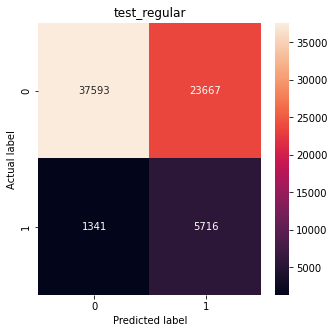

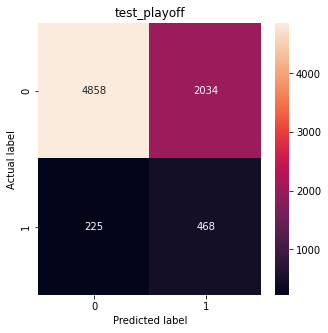

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

dataset_test = "test_regular"
x_test, y_test = getData(dataset_test)
y_pred = model_resampled.predict(x_test, batch_size=BATCH_SIZE)
resampled_results = model_resampled.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
plot_cm(y_test, y_pred, name=dataset_test)

dataset_test = "test_playoff"
x_test, y_test = getData(dataset_test)
y_pred = model_resampled.predict(x_test, batch_size=BATCH_SIZE)
resampled_results = model_resampled.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=0)
plot_cm(y_test, y_pred, name=dataset_test)

# Push to comet

In [17]:
model_weighted.save('nn_weighted.h5')

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 14 22:01:49 2022

@author: rajes
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.ticker as ticker



def plot_ROC(y_val,pred_probs):
    """
    Plots an ROC curve for the given y (ground truth) and model probabilities, and calculates the AUC.
    """
    fpr, tpr, _ = roc_curve(y_val, pred_probs)
    roc_auc = auc(fpr,tpr)
    #plt.figure()
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    #Include a random classifier baseline, i.e. each shot has a 50% chance of being a goal
    
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    plt.title('ROC Curves', fontsize=16)
    plt.legend(loc="lower right")
    
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    plt.show()
    
def calc_percentile(pred_probs, y_val):
    
    #Create a df for shot probabilities
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Not_Goal_prob", 1: "Goal_prob"})
    
    # Combining 'Goal Probability' and 'Is Goal' into one df. 
    df_probs = pd.concat([df_probs["Goal_prob"].reset_index(drop=True), y_val["isGoal"].reset_index(drop=True)],axis=1)
    
    # Computing and adding Percentile Column
    percentile_values=df_probs['Goal_prob'].rank(pct=True)
    df_probs['Percentile'] = percentile_values*100
    df_percentile = df_probs.copy()
    
    return df_percentile

def goal_rate(df_percentile):
   
    rate_list = []
    
    # Find total number of goals
    #total_goals = df_percentile['isGoal'].value_counts()[1]
   
    
    bin_width = 5

    i = 0
    i_list = []
    
    
    while i< (100-bin_width+1):  # 95 is the lower bound of last bin
        i_list.append(i)

        # i-th bin size
        bin_lower_bound = i
        bin_upper_bound = i + bin_width

        # finding rows have percentiles fall in this range
        bin_rows = df_percentile[(df_percentile['Percentile']>=bin_lower_bound) & (df_percentile['Percentile']<bin_upper_bound)]
        
        # Calculating the goal rate from total number of goals and shots in each bin_rows
        goals = bin_rows['isGoal'].value_counts()[1]      
        shots = len(bin_rows) #total shots in bin_rows
        rate = (goals/shots)*100 # goal rate in pecerntage

        rate_list.append(rate)

        i+=bin_width
    
    # Creating a new dataframe Combining goal rate list and percentile list 
    goal_rate_df = pd.DataFrame(list(zip(rate_list, i_list)),columns=['Rate', 'Percentile'])
    
    return goal_rate_df

def plot_goal_rates(goal_rate_df):
    plt.figure(figsize=(8,6))
    
    ax = plt.gca()
    ax.grid()
    
    ax.set_facecolor('0.95')
    x = goal_rate_df['Percentile']
    y = goal_rate_df['Rate']
    plt.plot(x,y)

    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    
    #ax.legend(['Model 1'])
    
    plt.xlabel('Shot probability model percentile', fontsize=16)
    plt.title('Goal Rate', fontsize=16)
    plt.ylabel('Goals / (Shots+Goals)%', fontsize=16)
    plt.savefig('goal_rate_plot.png')
    plt.show()
    
def plot_cumulative_goal_rates(df_percentile):
    
    plt.figure(figsize=(8,6))
    df_precentile_only_goal = df_percentile[df_percentile['isGoal'] == 1]
    
    ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile)
    
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals", fontsize=16)
    #plt.legend(loc='lower right')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.savefig('cumulative_goal_rate.png')
    ax.legend(['Neural Network'])
    plt.show()
    
def plot_calibration_curve_prediction(y_val, pred_probs):
    plt.figure(figsize=(8,6))
    
    ax = CalibrationDisplay.from_predictions(y_val['isGoal'],pred_probs, n_bins=50)
   
    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    ax.set_title(f"Calibration Curve", fontsize=16)
    plt.ylabel('Fraction of positives', fontsize=16)
    plt.xlabel('Mean predicted probability', fontsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.savefig('calibration_curve.png')
    plt.show()


In [1]:
!pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1973/1973 [==============================] - 3s 2ms/step


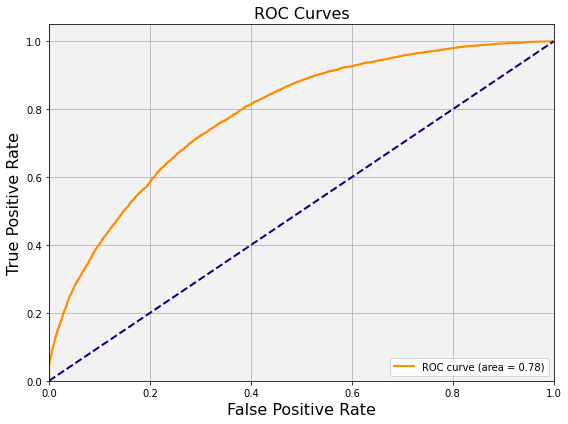

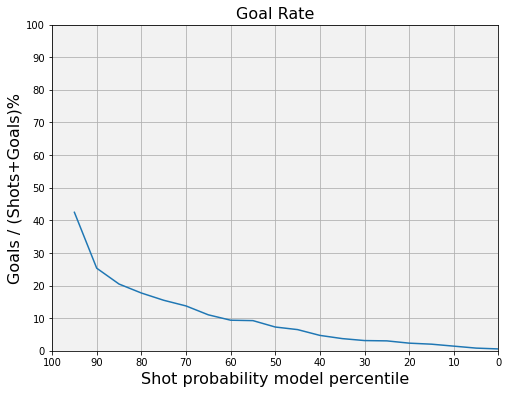

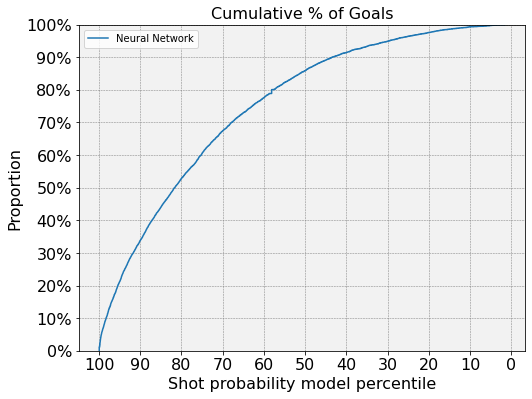

<Figure size 576x432 with 0 Axes>

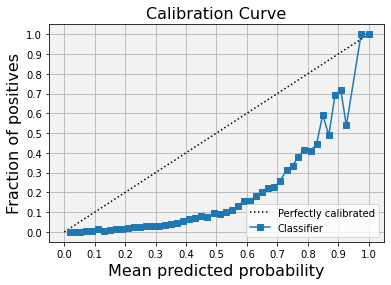

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: keras, tensorflow, sklearn, tensorboard. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-project/ift6758-project/dc59e8ced4654a5d8c3d2fc3041c74f0
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.6560286497535931
COMET INFO:     f1_score  : 0.31130429264887843
COMET INFO:     precision : 0.1947443632899333
COMET INFO:     recall    : 0.7754069859333017
COMET INFO:     roc_auc   : 0.784614666018422
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1zHV14veBWbQfJRAiKDi7X_pOzBT7DkMu
COMET INFO:   Uploads:
COMET IN

In [28]:
#!/usr/bin/env python
# coding: utf-8
from comet_ml import Experiment
import os
from sklearn import metrics

def push_best_nn(X, y, model, experiment_name, tags=[], model_name="nn_weighted"):
    # Predict on validation set
    # y_pred = model.predict(X)

    #Probability estimates
    y_ = model.predict(X)
    y_pred = list(map(lambda x: 0 if x<0.5 else 1, y_))
    pred_probs = list(map(lambda x: [round(1-x, 8), x], y_.flatten()))

    #Model Evaultion Metrics
    accuracy = metrics.accuracy_score(y, y_pred)
    f1_score = metrics.f1_score(y, y_pred)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    cf_matrix = metrics.confusion_matrix(y, y_pred)
    roc_auc = metrics.roc_auc_score(y, y_)
    
    # #ROC AUC Curve
    plot_ROC(y, y_)

    y = pd.DataFrame(y, columns=["isGoal"])

    # # #Goal Rate Plot
    df_percentile = calc_percentile(pred_probs, y)
    goal_rate_df = goal_rate(df_percentile)
    plot_goal_rates(goal_rate_df)
        
    # #Cumulative Goal Rate Plot
    plot_cumulative_goal_rates(df_percentile)
        
    # #Calibration Curve
    plot_calibration_curve_prediction(y, y_) 
    
    metrics_dict = { 'accuracy': accuracy,
                        "f1_score": f1_score,
                        "precision": precision,
                        "recall": recall,
                        "roc_auc": roc_auc}

    experiment = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),  
        project_name="ift6758-project",
        workspace="ift6758-project",
        auto_output_logging="simple",
    )

    experiment.add_tags(tags)
    experiment.log_parameters(model.trainable_variables)
    experiment.log_metrics(metrics_dict)
    experiment.log_confusion_matrix(matrix=cf_matrix)
    experiment.log_image('roc_curve.png', name= experiment_name + '_roc_curve.png', overwrite=True)
    experiment.log_image('goal_rate_plot.png', name= experiment_name + '_goal_rate_plot.png', overwrite=True)
    experiment.log_image('cumulative_goal_rate.png', name= experiment_name + '_cumulative_goal_rate_plot.png', overwrite=True)
    experiment.log_image('calibration_curve.png', name= experiment_name + '_calibration_curve.png', overwrite=True)
    experiment.log_model("best_nn", model_name + ".h5")
    
    return pred_probs, accuracy, f1_score, precision, recall, roc_auc, cf_matrix

nn = push_best_nn(x_val, y_val, model_weighted, "best_nn", ["nn", "nn_weighted", "best"])